## **MMCCI Multi-Platform Aging Example**

In this example, we have young and aged Visium and STOmics mouse brain samples.
Each sample has been run through stLearn CCI and saves as CCIData objects.

We will integrate the samples together, and then run analysis on the integrated results.

### **Integration**

These CCI results will be integrated together and analysed in this notebook with the following steps:
1. Integrate within platforms for aged and young
2. Integrate between technologies for aged and young
3. Comparitive CCI analysis between aged and young

In [1]:
import mmcci

#### Load CCIData objects

This data is available on the GitHub repo and is created from stLearn.

Information on loading in CCI results from different tools is available [here](examples/loading_CCI_results.ipynb)

In [2]:
samples = [
    mmcci.io.read_CCIData('../data/brain_aging/aged_visium_1.pkl'),
    mmcci.io.read_CCIData('../data/brain_aging/aged_visium_2.pkl'),
    mmcci.io.read_CCIData('../data/brain_aging/aged_visium_3.pkl'),
    mmcci.io.read_CCIData('../data/brain_aging/aged_visium_4.pkl'),
    mmcci.io.read_CCIData('../data/brain_aging/young_visium_1.pkl'),
    mmcci.io.read_CCIData('../data/brain_aging/young_visium_2.pkl'),
    mmcci.io.read_CCIData('../data/brain_aging/young_visium_3.pkl'),
    mmcci.io.read_CCIData('../data/brain_aging/young_visium_4.pkl'),
    mmcci.io.read_CCIData('../data/brain_aging/aged_stomics_1.pkl'),
    mmcci.io.read_CCIData('../data/brain_aging/aged_stomics_2.pkl'),
    mmcci.io.read_CCIData('../data/brain_aging/young_stomics_1.pkl'),
    mmcci.io.read_CCIData('../data/brain_aging/young_stomics_2.pkl')
    ]

In [3]:
samples[0]

CCIData object with assays: {'raw': '784 LR pairs'} and metadata: {'n_spots': 2855, 'platform': 'visium', 'age': 'aged'}

In [3]:
# These colours will be used for plotting later

colors = {
    'Ependymal': '#1f77b4',
    'Astrocytes': '#ff7f0e',
    'Vascular': '#2ca02c',
    'Oligos': '#d62728',
    'Neurons': '#9467bd',
    'Microglia': '#8c564b',
    'Immune': '#e377c2',
    'PeripheralGlia': '#7f7f7f'
    }

#### 1. Integrate within platforms

This step first normalises the samples based on the number of spots, then it integrates the CCI results together

In [4]:
for i in range(len(samples)):
    
    # Scale by number of Visium/STOmics spots
    # This creates a new assay called 'scaled'
    samples[i] = samples[i].scale_by_nspots()
    
    # Filter out any interactions with a non-significant p-value
    # This creates a new assay called 'filtered'
    samples[i] = samples[i].filter_by_p_vals(assay='scaled')
    
    # Calculate overall interaction scores by summing all LR interactions
    # This creates a new network in the assay called 'overall'
    samples[i] = samples[i].calc_overall(assay='filtered')
    
# Perform integration using the 'scaled' assay since the filtering will be done post-integration
# The 'method' parameter specifies the minimum number of samples that must have a specific LR pair to be included in the integrated sample
# The 'strict' parameter specifies whether interactions scores have to be non-zero in the majority of samples to be included in the integrated sample

aged_visium = mmcci.it.lr_integration(samples[0:4], method=">=50%", strict=True, assay="scaled", metadata={'platform': 'visium'})
young_visium = mmcci.it.lr_integration(samples[4:8], method=">=50%", strict=True, assay="scaled", metadata={'platform': 'visium'})
aged_stomics = mmcci.it.lr_integration(samples[8:10], method=">=50%", strict=True, assay="scaled", metadata={'platform': 'stomics'})
young_stomics = mmcci.it.lr_integration(samples[10:12], method=">=50%", strict=True, assay="scaled", metadata={'platform': 'stomics'})

Integrating p values: 100%|██████████| 1253/1253 [00:07<00:00, 157.77it/s]


Then we remove the statistically insignificant interactions and calculate an overall network

In [5]:
aged_visium = aged_visium.filter_by_p_vals().calc_overall(assay='filtered')
young_visium = young_visium.filter_by_p_vals().calc_overall(assay='filtered')
aged_stomics = aged_stomics.filter_by_p_vals().calc_overall(assay='filtered')
young_stomics = young_stomics.filter_by_p_vals().calc_overall(assay='filtered')

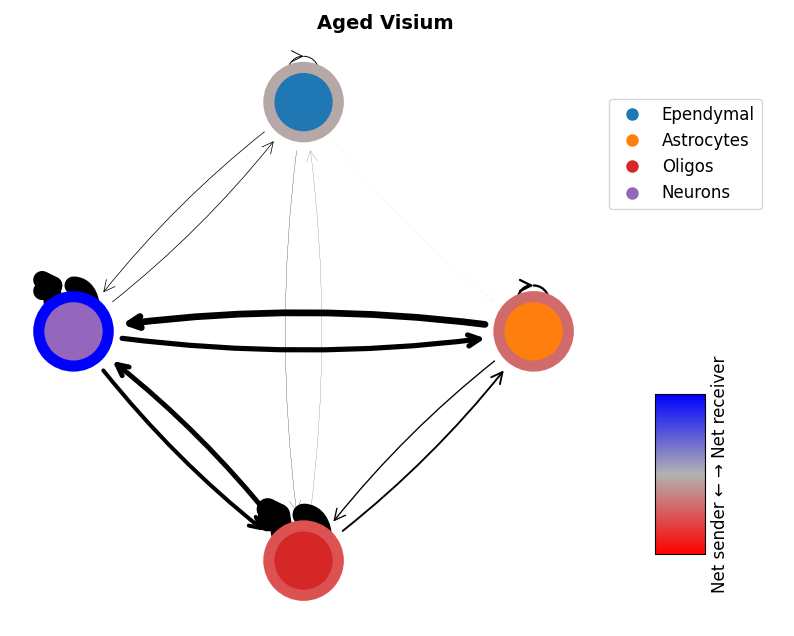

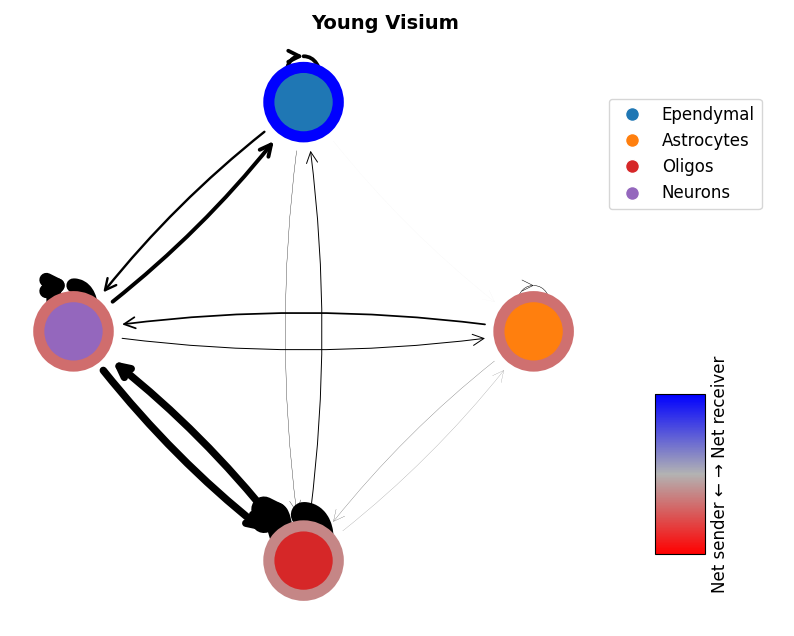

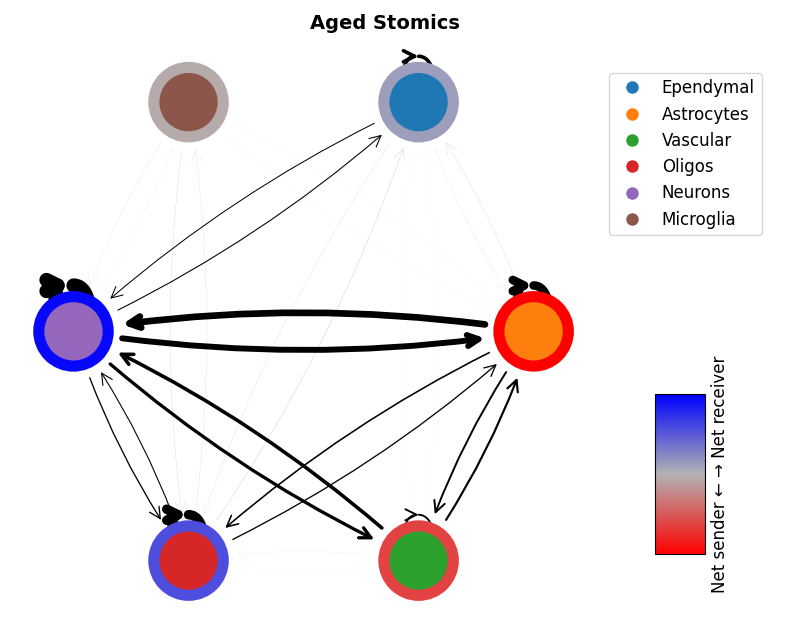

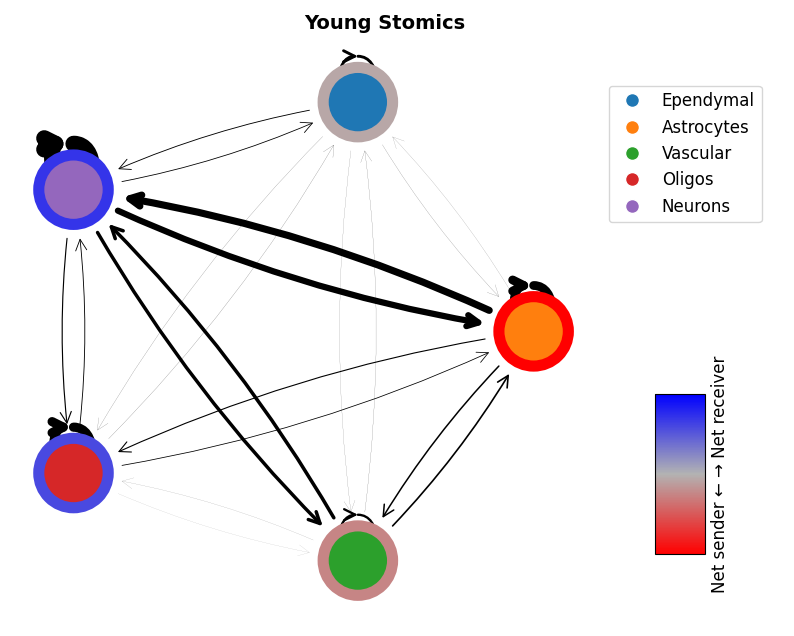

In [6]:
# plot the networks
mmcci.plt.network_plot(aged_visium.assays['filtered']['overall'], node_colors=colors, title='Aged Visium')
mmcci.plt.network_plot(young_visium.assays['filtered']['overall'], node_colors=colors, title='Young Visium')
mmcci.plt.network_plot(aged_stomics.assays['filtered']['overall'], node_colors=colors, title='Aged Stomics')
mmcci.plt.network_plot(young_stomics.assays['filtered']['overall'], node_colors=colors, title='Young Stomics')

#### 3. Integrate between platforms

This step first normalises the samples based on the number of interactions, then it integrates the samples

In [7]:
# calculate scale factors between the two platforms
aged_scale_factors = mmcci.it.calc_scale_factors([aged_visium, aged_stomics], assay='raw')
young_scale_factors = mmcci.it.calc_scale_factors([young_visium, young_stomics], assay='raw')

# scale the data using the calculated scale factors
aged_visium = aged_visium.scale(aged_scale_factors['visium'], assay='raw')
young_visium = young_visium.scale(young_scale_factors['visium'], assay='raw')
aged_stomics = aged_stomics.scale(aged_scale_factors['stomics'], assay='raw')
young_stomics = young_stomics.scale(young_scale_factors['stomics'], assay='raw')

# integrate the scaled data
aged = mmcci.it.lr_integration([aged_visium, aged_stomics], method=">50%", strict=True, assay="scaled", metadata={'age': 'aged'})
young = mmcci.it.lr_integration([young_visium, young_stomics], method=">50%", strict=True, assay="scaled", metadata={'age': 'young'})

Integrating p values: 100%|██████████| 1294/1294 [00:08<00:00, 155.08it/s]


In [8]:
# filter and calculate overall scores
aged = aged.filter_by_p_vals().calc_overall(assay='filtered')
young = young.filter_by_p_vals().calc_overall(assay='filtered')

Now we can visualise our integrated samples, either as network plots or chord plots

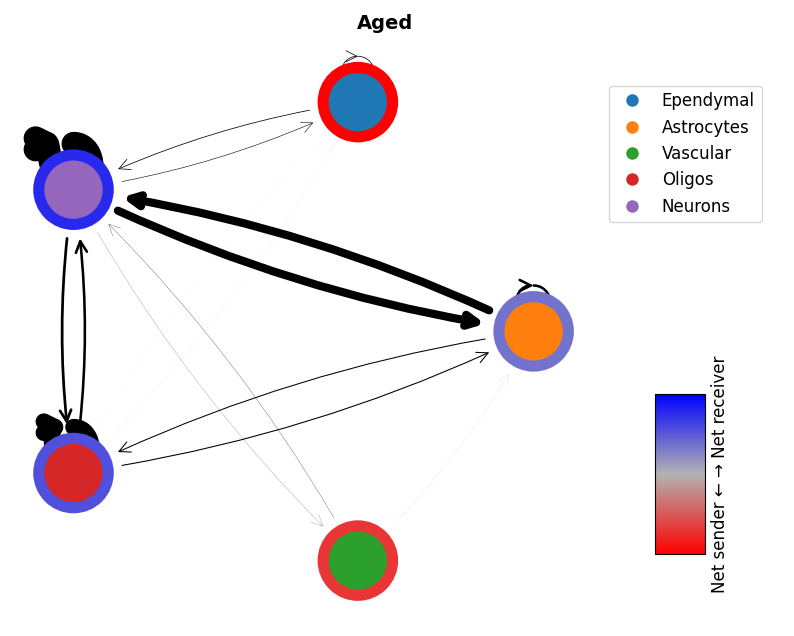

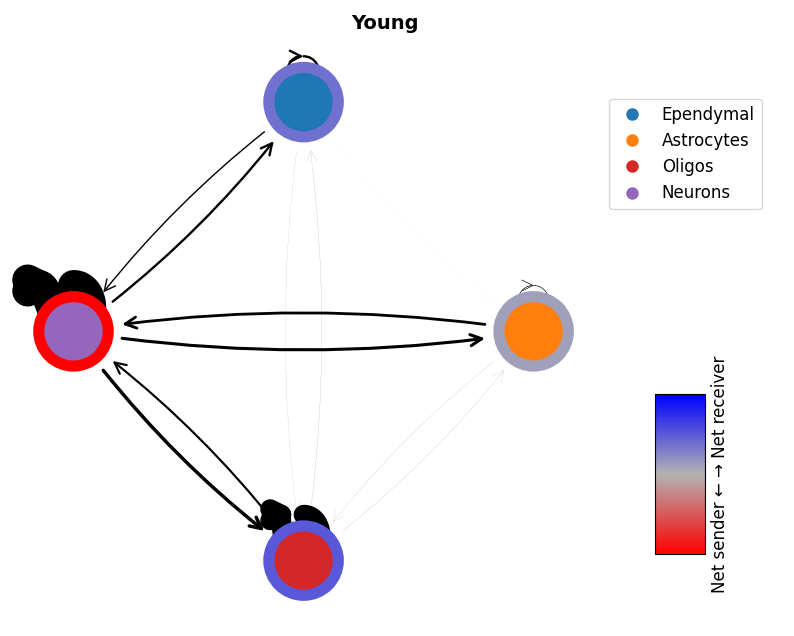

In [9]:
# Network plots
mmcci.plt.network_plot(aged.assays['filtered']['overall'], node_colors=colors, title='Aged')
mmcci.plt.network_plot(young.assays['filtered']['overall'], node_colors=colors, title='Young')

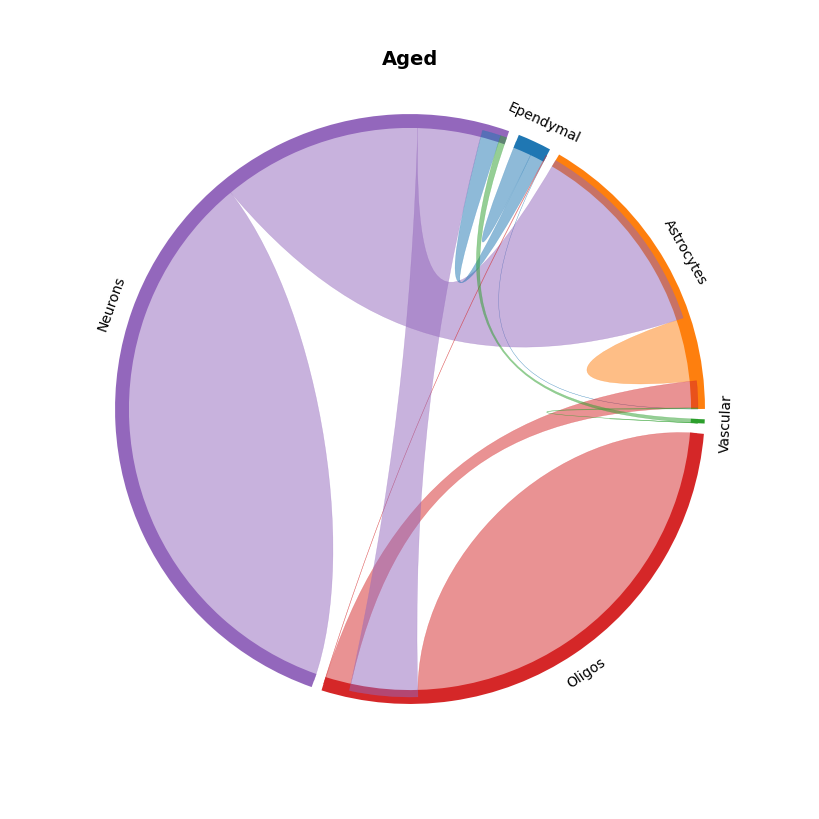

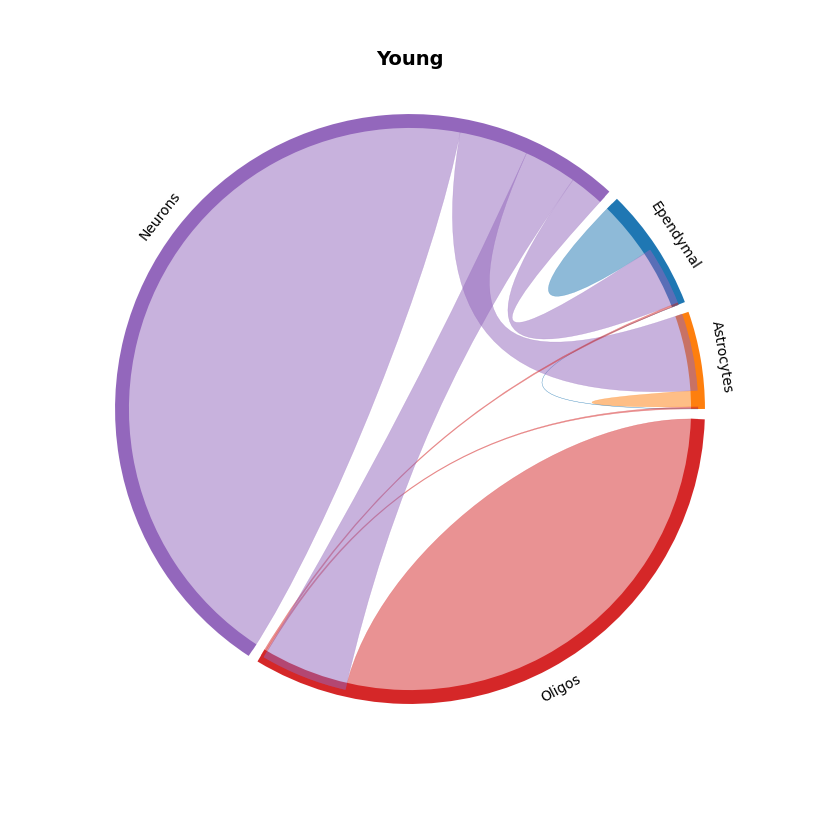

In [10]:
# Chord plots
mmcci.plt.chord_plot(aged.assays['filtered']['overall'], colors=colors, title='Aged')
mmcci.plt.chord_plot(young.assays['filtered']['overall'], colors=colors, title='Young')

## **Analysis**

Now there are many analyses we can run a sample (integrated or non-integrated) such as:
1. Calculate the difference between two samples
2. Find dissimilar LR pairs between samples
3. Query the LR pairs interacting between different cell types
4. LR network clustering
5. Pathway clustering
6. LR interaction clustering

#### 1. Calculate the difference between the integrated aged and young samples

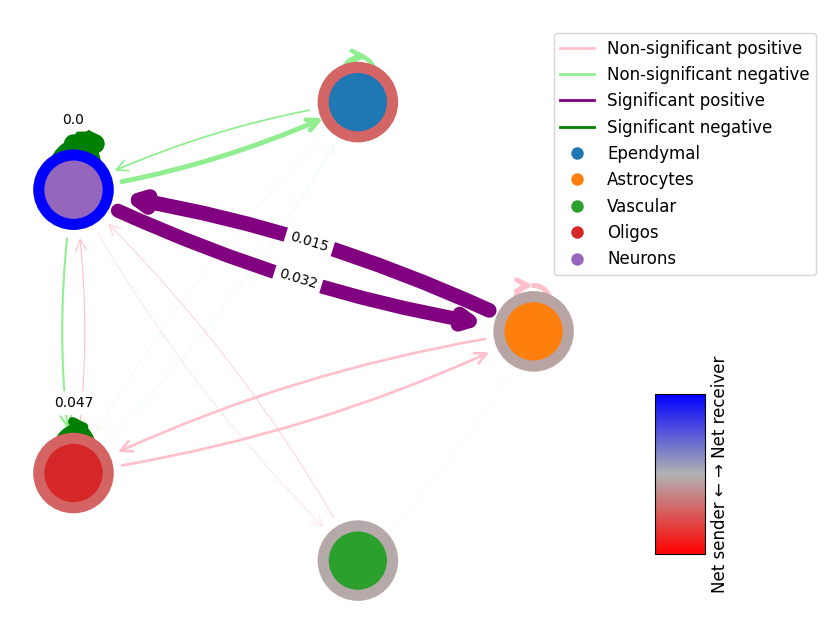

In [11]:
# get the difference between the two networks
# this will return the difference in interaction scores and the p-values of the differences
# p-values are calculated using permutation testing
diff = mmcci.an.get_network_diff(aged.assays['filtered']['overall'], young.assays['filtered']['overall'])
mmcci.plt.network_plot(diff['diff'], diff['p_vals'], diff_plot=True, edge_weight=60, node_colors=colors)

#### 2. Find dissimilar LR pairs between the integrated aged and young samples

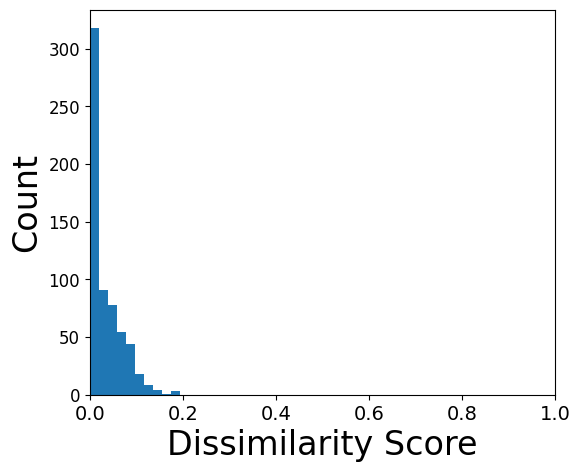

Overall Network Aged vs Young Dissimilarity Score is: 0.23290906762113986


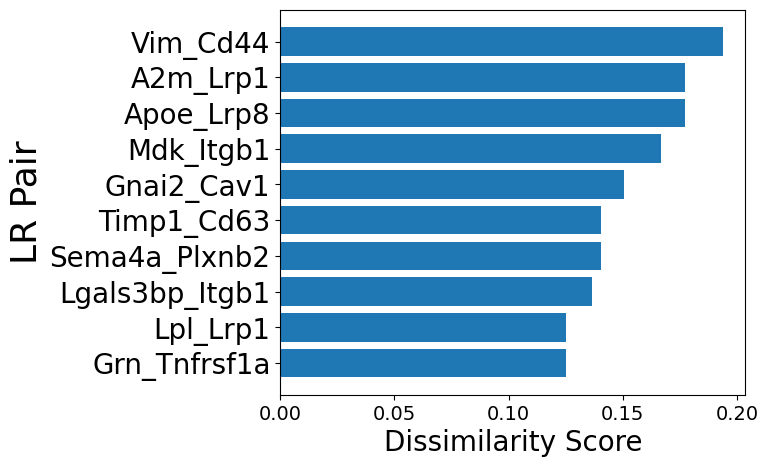

In [12]:
# this calculates a dissimilarity score for each LR pair based on how different their CCI networks are
dissimilarity_scores = mmcci.an.calculate_dissim(aged, young, assay='filtered')
mmcci.plt.dissim_hist(dissimilarity_scores)
    
## Sort LR Pairs from high to low dissimilarities
print("Overall Network Aged vs Young Dissimilarity Score is: " + str(mmcci.sc.dissimilarity_score(aged.assays['filtered']['overall'], young.assays['filtered']['overall'])))

mmcci.plt.lr_top_dissimilarity(dissimilarity_scores, x_label_size=20, y_label_size=26, y_tick_size=20, figsize=(6,5))

We can also do a difference plot for a specific LR pair between conditions

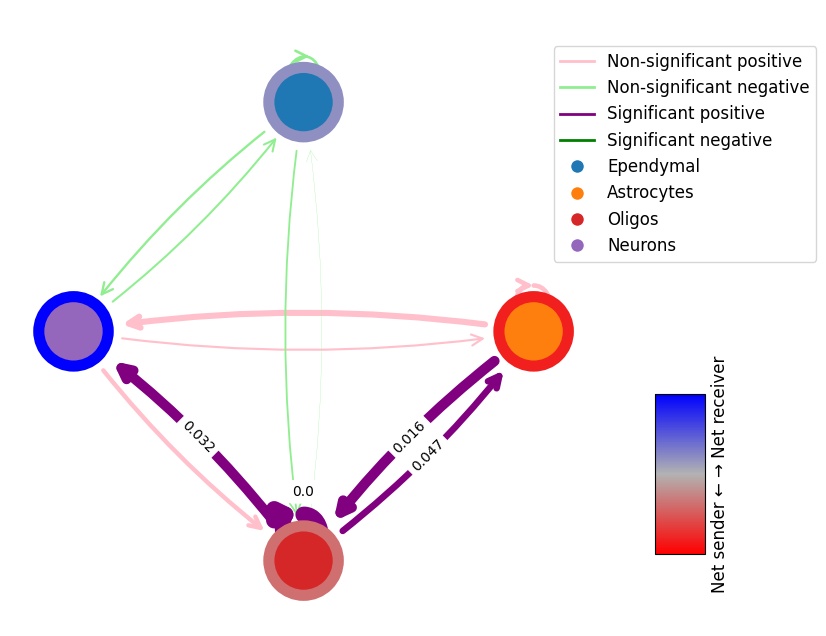

In [13]:
diff = mmcci.an.get_network_diff(aged.assays['filtered']['cci_scores']['Vim_Cd44'], young.assays['filtered']['cci_scores']['Vim_Cd44'])
mmcci.plt.network_plot(diff['diff'], diff['p_vals'], diff_plot=True, node_colors=colors)

#### 3. Get LR pairs from a sender (Astrocytes) and reciever (Neurons) cell type pair

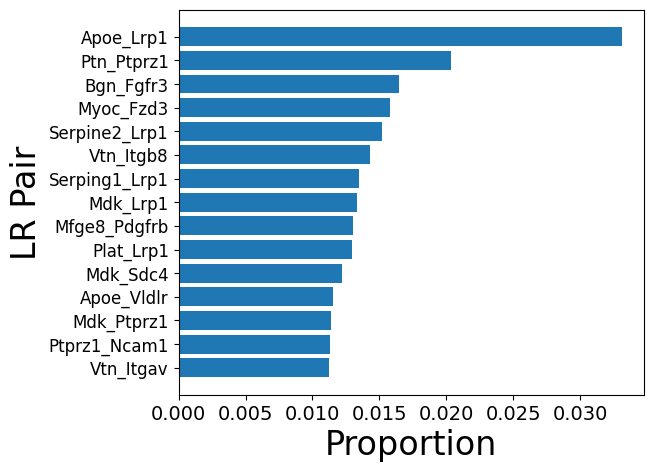

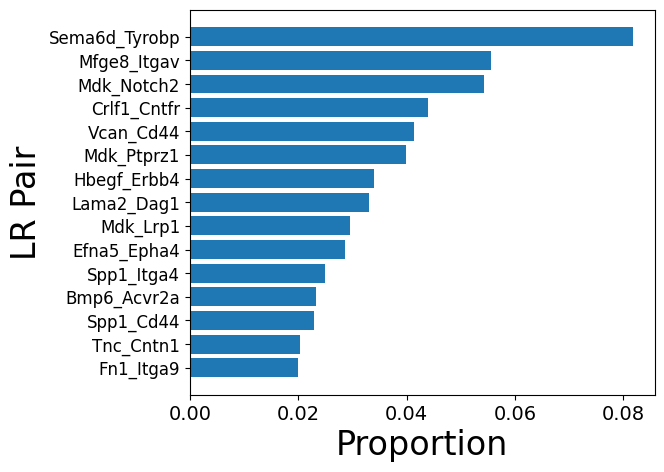

In [14]:
# Aged
mmcci.plt.lrs_per_celltype(aged, sender="Astrocytes", receiver="Neurons")

# Young
mmcci.plt.lrs_per_celltype(young, sender="Astrocytes", receiver="Neurons")

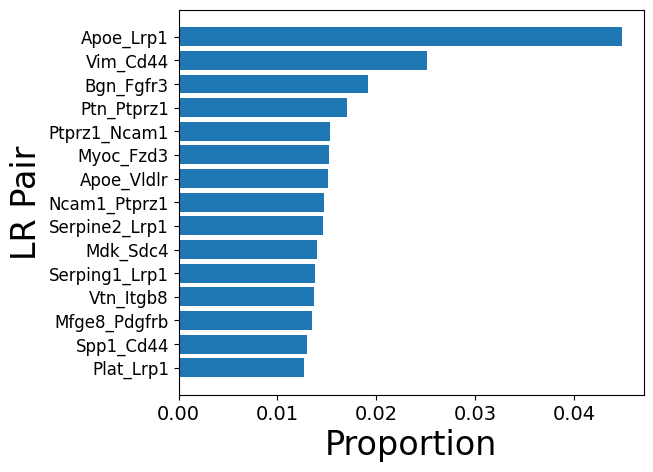

In [15]:
# Aged
mmcci.plt.lrs_per_celltype(aged, sender="Astrocytes")

#### 4. Run LR network clustering

This analysis clusters LR pairs with similar networks together. \
Here we show an example of one aged cluster and one young cluster and run GSEA analysis on the LRs involved

In [ ]:
aged = mmcci.an.cell_network_clustering(aged, assay='filtered', n_clusters=0)

mmcci.plt.chord_plot(aged.assays['cluster_0']['overall'], colors=colors, title='Aged Cluster 0')
mmcci.an.run_gsea(aged, assay='cluster_0', organism='mouse', return_results=False)

Computing dissimilarity scores for complex interaction networks...


Processing: 100%|██████████| 374/374 [00:37<00:00, 10.00it/s]


Computing Principal Components of weighted graph ...
Performing Clustering and Ranking within clusters...
Computing Dissimilarity Scores for single interactions...


Processing:  54%|█████▍    | 138/254 [00:09<00:07, 14.77it/s]

Computing dissimilarity scores for complex interaction networks...


Processing: 100%|██████████| 170/170 [00:08<00:00, 19.37it/s]


Computing Principal Components of weighted graph ...
Performing Clustering and Ranking within clusters...
Computing Dissimilarity Scores for single interactions...


Processing: 100%|██████████| 258/258 [00:17<00:00, 14.34it/s]


Computing Principal Components of weighted graph ...
Performing Clustering and Ranking within clusters...


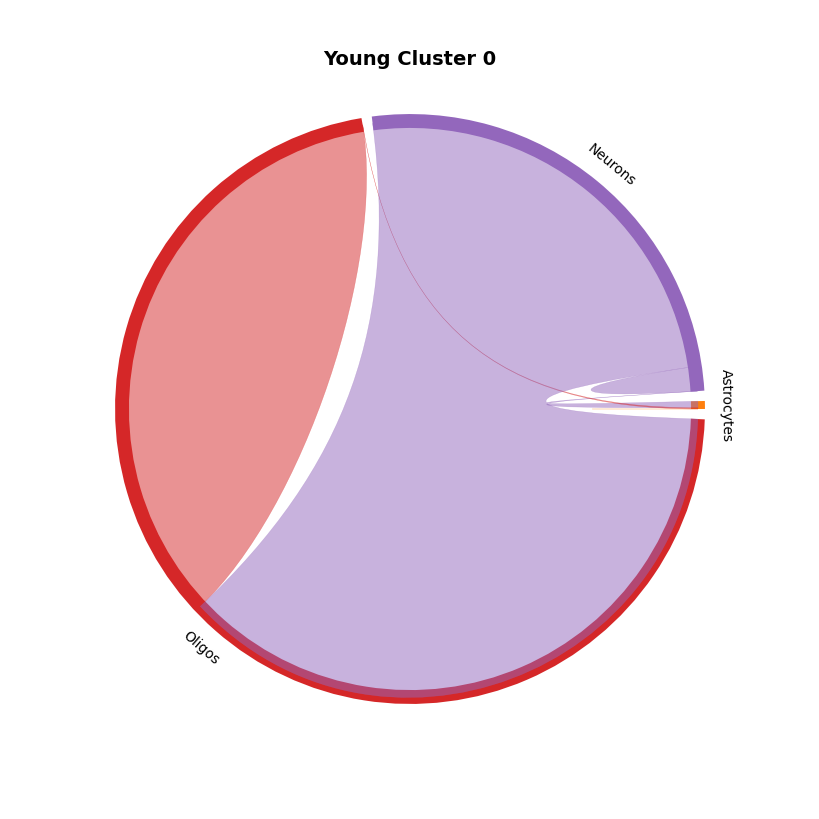

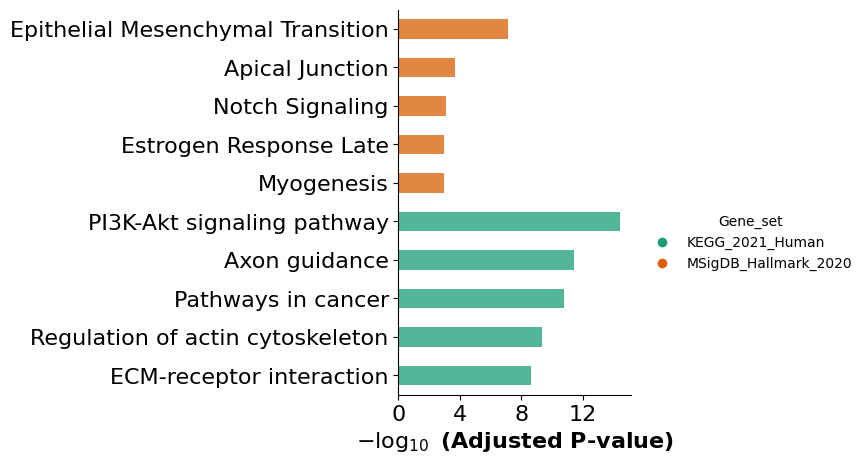

In [ ]:
young = mmcci.an.cell_network_clustering(young, assay='filtered', n_clusters=0)

mmcci.plt.chord_plot(young.assays['cluster_0']['overall'], colors=colors, title='Young Cluster 0')
mmcci.an.run_gsea(young, assay='cluster_0', organism='mouse', return_results=False)

#### 5. Run interaction pathway analysis

This analysis clusters LR pairs that are part of a GSEA pathway \
Here we show an example of the complement pathway in the aged integrated sample

Number of interactions in complement: 50


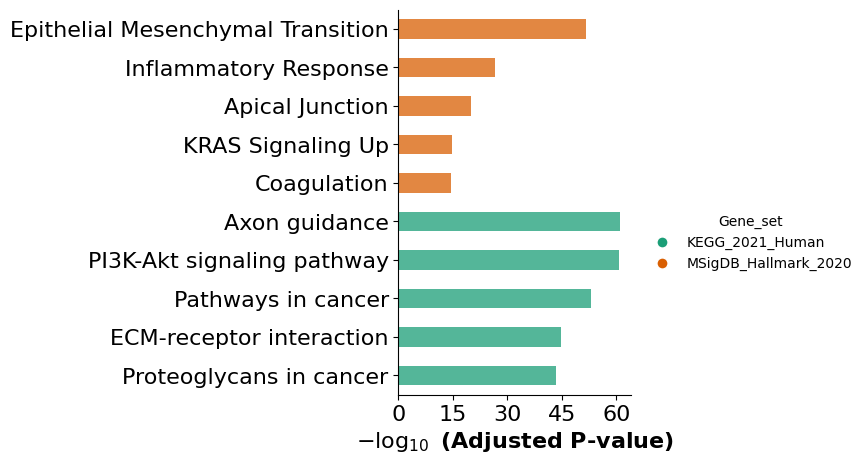

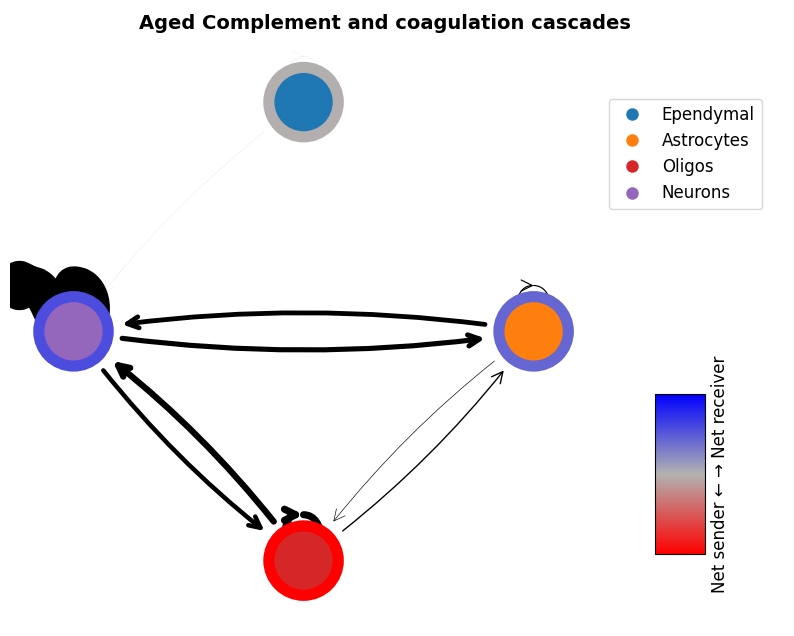

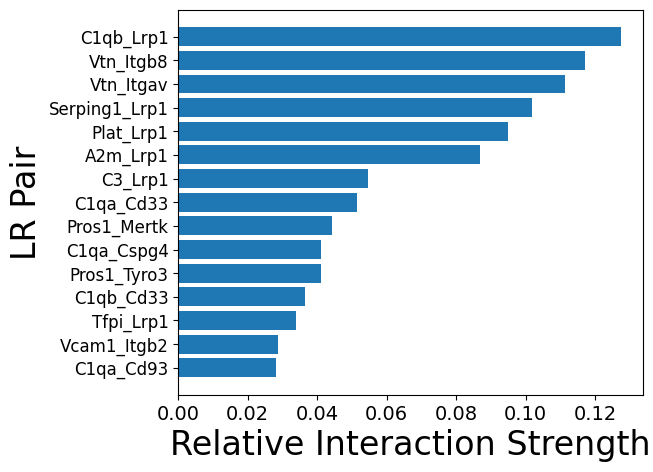

In [ ]:
# First we run the pathway analysis to find the LR pairs involved in each pathway
results = mmcci.an.run_gsea(aged, organism="mouse", gene_sets=["KEGG_2021_Human", "MSigDB_Hallmark_2020"], show_dotplot=False)

# We subset the LR pairs to only include those involved in the Complement and coagulation cascades pathway
aged = mmcci.an.pathway_subset(aged, gsea_results=results, terms=["Complement and coagulation cascades"], assay_name="complement", strict=False)
mmcci.plt.network_plot(aged.assays['complement']['overall'], node_colors=colors, title='Aged Complement and coagulation cascades')
mmcci.plt.lr_barplot(aged, assay="complement")

#### 6. Run LR interaction clustering

This analysis requires an AnnData sample that has been processed through stLearn as input. It will cluster spots together with similar LR interaction scores.

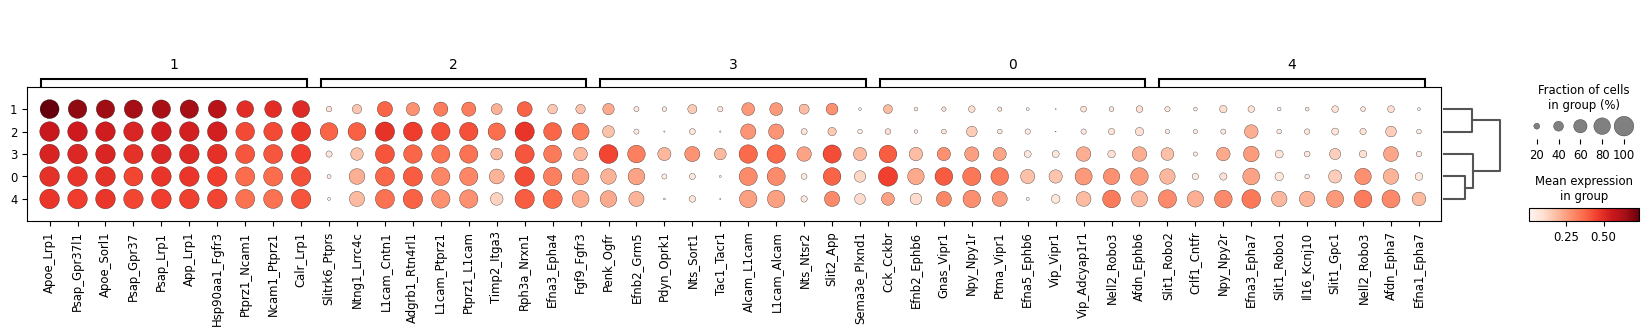

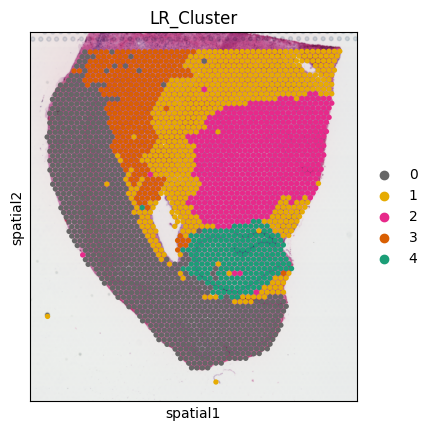

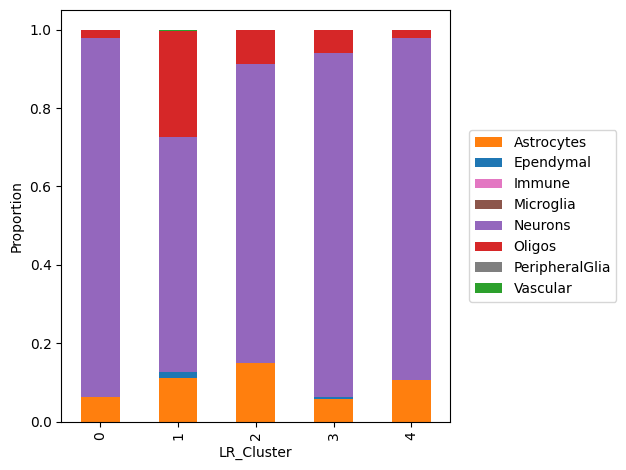

In [ ]:
data = mmcci.io.read_stLearn("../data/brain_aging/visium.h5ad", save_anndata=True)
mmcci.an.lr_interaction_clustering(data, cell_colors=colors)